In [64]:
import copy
from pathlib import Path
import warnings
from typing import Dict, List, Tuple, Union

import torch
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# Test Dataset

In [41]:
data = pd.read_pickle('../M5_Dataset/tft_dataset.pkl')
data["month"] = data["month"].astype(str).astype("category")

special_days = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
snap_days = ['snap_CA', 'snap_TX', 'snap_WI']

data[snap_days] = data[snap_days].astype(str).astype("category")

train_dataset = data[data.d < 1912]
test_dataset = data[data.d >= 1912]

max_prediction_length = 30
max_encoder_length = 90
training_cutoff = train_dataset["d"].max() - max_prediction_length

test_encoder = train_dataset[lambda x: x.d > x.d.max() - max_encoder_length]
test_dataset = pd.concat([test_encoder, test_dataset], ignore_index=True)
test_cutoff = test_dataset["d"].max() - max_prediction_length

In [42]:
test_dataset

,store_id,dept_id,state_id,cat_id,Node,d,sold,date,weekday,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,CA_1,FOODS_1,CA,FOODS,CA_1_FOODS_1,1822,401.0,2016-01-24,Sunday,2,1,-,-,-,-,0,0,0
1,CA_1,FOODS_2,CA,FOODS,CA_1_FOODS_2,1822,621.0,2016-01-24,Sunday,2,1,-,-,-,-,0,0,0
2,CA_1,FOODS_3,CA,FOODS,CA_1_FOODS_3,1822,2418.0,2016-01-24,Sunday,2,1,-,-,-,-,0,0,0
3,CA_1,HOBBIES_1,CA,HOBBIES,CA_1_HOBBIES_1,1822,431.0,2016-01-24,Sunday,2,1,-,-,-,-,0,0,0
4,CA_1,HOBBIES_2,CA,HOBBIES,CA_1_HOBBIES_2,1822,44.0,2016-01-24,Sunday,2,1,-,-,-,-,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,WI_3,FOODS_3,WI,FOODS,WI_3_FOODS_3,1941,2632.0,2016-05-22,Sunday,2,5,-,-,-,-,0,0,0
8396,WI_3,HOBBIES_1,WI,HOBBIES,WI_3_HOBBIES_1,1941,305.0,2016-05-22,Sunday,2,5,-,-,-,-,0,0,0
8397,WI_3,HOBBIES_2,WI,HOBBIES,WI_3_HOBBIES_2,1941,37.0,2016-05-22,Sunday,2,5,-,-,-,-,0,0,0
8398,WI_3,HOUSEHOLD_1,WI,HOUSEHOLD,WI_3_HOUSEHOLD_1,1941,723.0,2016-05-22,Sunday,2,5,-,-,-,-,0,0,0


# Test models

In [70]:
dirs = glob('lightning_logs/default/version_*/')
dirs.sort()
dirs

['lightning_logs/default/version_2/',
 'lightning_logs/default/version_5/',
 'lightning_logs/default/version_6/']

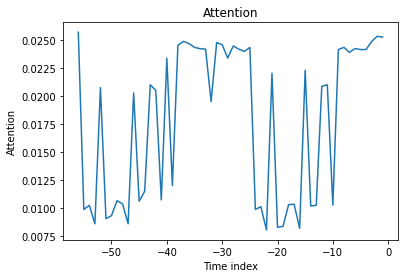

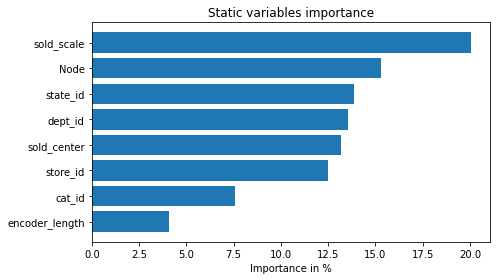

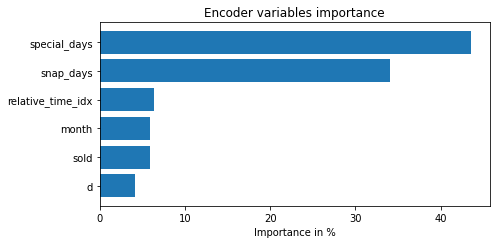

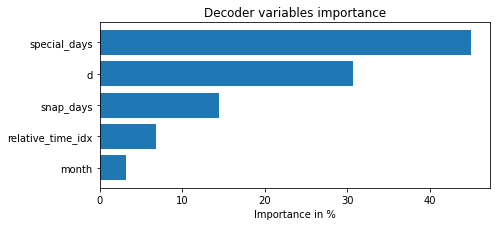

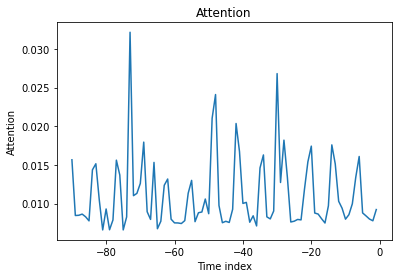

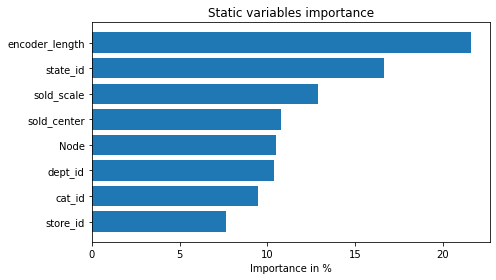

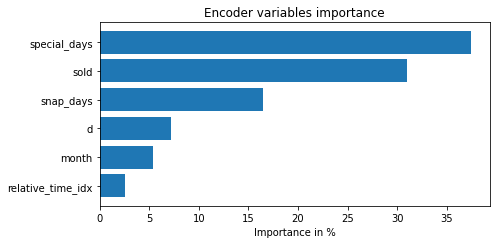

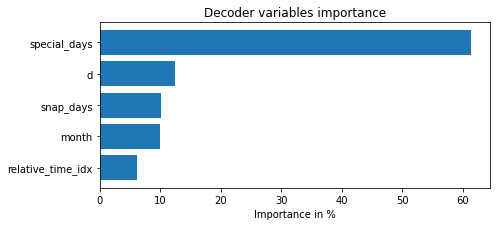

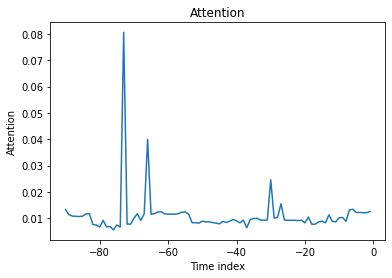

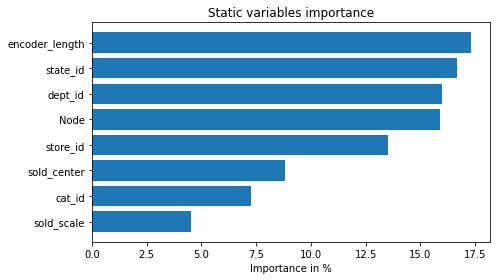

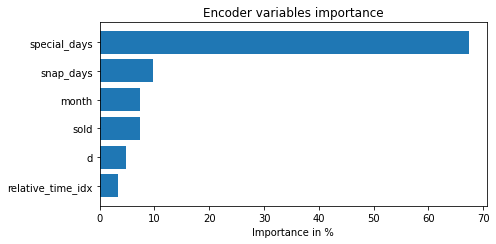

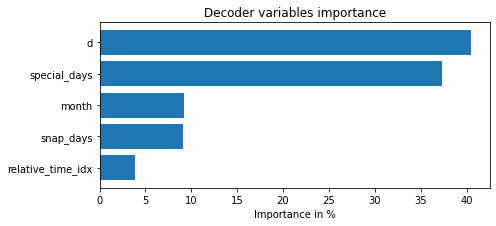

In [71]:
fig_list = []

for dr in dirs:
    path = glob(dr+'checkpoints/*.ckpt')
    load_tft = TemporalFusionTransformer.load_from_checkpoint(path[0])
    pred, x = load_tft.predict(test_dataset, mode="raw", return_x=True)
    interpretation = load_tft.interpret_output(pred, reduction="sum")
    figures = load_tft.plot_interpretation(interpretation)
    fig_list.append(figures)

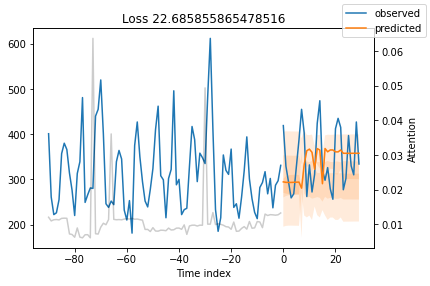

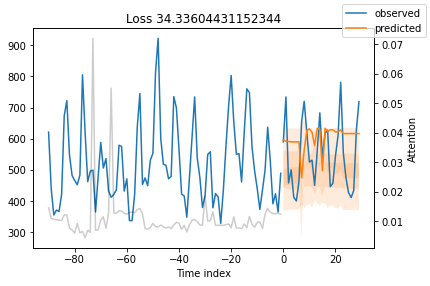

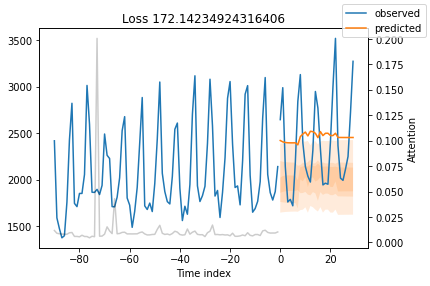

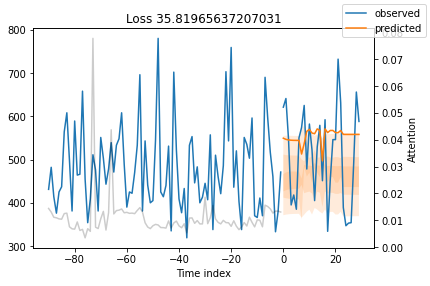

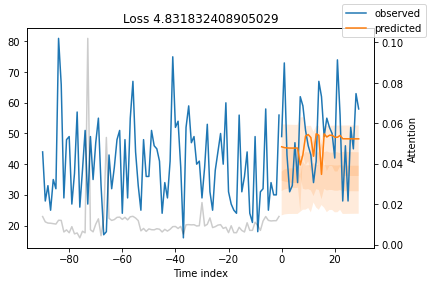

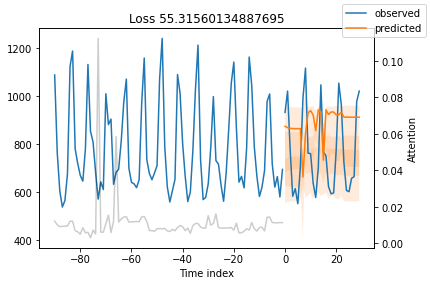

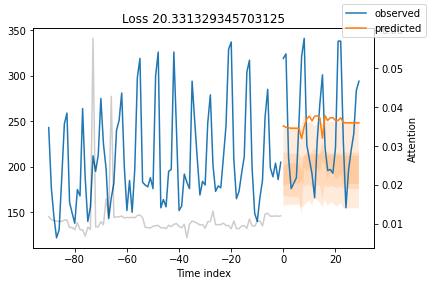

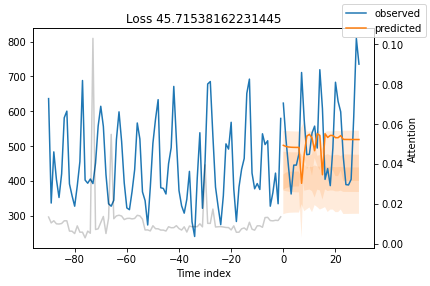

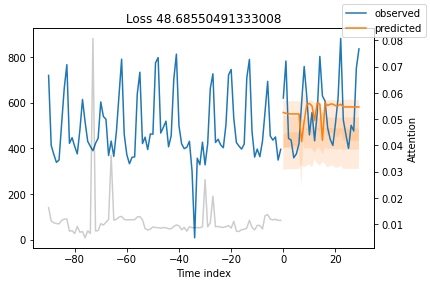

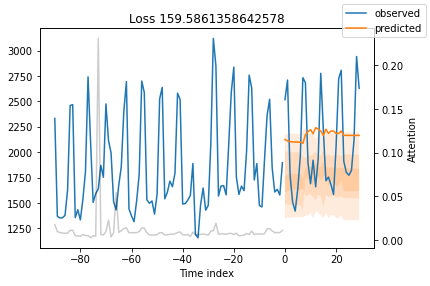

In [96]:
for idx in range(10):
    load_tft.plot_prediction(x, pred, idx=idx, add_loss_to_title=True);